In [13]:
from pathlib import Path
import numpy as np
import xarray as xr

import echopype as ep

In [2]:
data_path = "/Users/wu-jung/code_git/echopype/echopype/test_data/ek60/DY1002_EK60-D20100318-T023008_rep_freq.raw"

In [3]:
ed = ep.open_raw(data_path, sonar_model="EK60")

09:25:43  parsing file DY1002_EK60-D20100318-T023008_rep_freq.raw, time of first ping: 2010-Mar-18 02:30:08


In [4]:
dup_freq_valueerror = (
    "Duplicated transducer nominal frequencies exist in the file. "
    "Operation is not valid."
)

In [5]:
Sv = ep.calibrate.compute_Sv(ed)

In [6]:
Sv

<xarray.Dataset>
Dimensions:                (channel: 6, ping_time: 609, range_sample: 4263,
                            filenames: 1, time3: 609)
Coordinates:
  * channel                (channel) <U37 'GPT  18 kHz 009072034d45 1-1 ES18-...
  * ping_time              (ping_time) datetime64[ns] 2010-03-18T02:30:08.778...
  * range_sample           (range_sample) int64 0 1 2 3 ... 4259 4260 4261 4262
  * time3                  (time3) datetime64[ns] 2010-03-18T02:30:08.7789998...
Dimensions without coordinates: filenames
Data variables:
    Sv                     (channel, ping_time, range_sample) float64 0.7307 ...
    echo_range             (channel, ping_time, range_sample) float64 0.0 ......
    frequency_nominal      (channel) float64 1.8e+04 3.8e+04 ... 1.2e+05 2e+05
    sound_speed            (channel, ping_time) float64 1.466e+03 ... 1.466e+03
    sound_absorption       (channel, ping_time) float64 0.003004 ... 0.04176
    sa_correction          (ping_time, channel) float64 -0.58 -0.61 ... -0.25
    gain_correction        (ping_time, channel) float64 23.0 22.97 ... 25.91
    equivalent_beam_angle  (channel, ping_time) float64 -17.47 -17.47 ... -20.78
    source_filenames       (filenames) <U99 '/Users/wu-jung/code_git/echopype...
    water_level            (channel, time3) float64 dask.array<chunksize=(6, 609), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.6.0
    processing_time:              2022-07-04T16:25:49Z
    processing_function:          calibrate.compute_Sv

In [7]:
er = Sv["echo_range"].isel(channel=2).dropna(dim="ping_time", how="any")
er_nan = Sv["echo_range"].isel(channel=2)

In [8]:
er.shape, er_nan.shape

((304, 4263), (609, 4263))

In [9]:
er.dims, er_nan.dims

(('ping_time', 'range_sample'), ('ping_time', 'range_sample'))

In [15]:
%%time
ping_time_idx = np.argwhere([dim == "ping_time" for dim in er.dims])[0][0]

CPU times: user 63 µs, sys: 7 µs, total: 70 µs
Wall time: 66.8 µs


In [16]:
%%time
er_unique_shape = np.unique(er, axis=ping_time_idx).shape

CPU times: user 227 ms, sys: 7.9 ms, total: 235 ms
Wall time: 235 ms


In [17]:
np.unique(er, axis=ping_time_idx).shape[ping_time_idx]

1

In [18]:
def _check_unique_echo_range(da):
    da = da.dropna(dim="ping_time", how="any")
    ping_time_idx = np.argwhere([dim == "ping_time" for dim in da.dims])[0][0]
    if np.unique(da, axis=ping_time_idx).shape[ping_time_idx] == 1:
        return xr.DataArray(data=True, coords={"channel": da["channel"].values})
    else:
        return xr.DataArray(data=False, coords={"channel": da["channel"].values})

In [19]:
if Sv["echo_range"].groupby("channel").apply(_check_unique_echo_range).all():
    print("unique!")

unique!


In [80]:
def _freq_MVBS(ds, rint, pbin):
    sv = 10 ** (ds["Sv"] / 10)  # average should be done in linear domain
    # set 1D coordinate using the 1st ping echo_range since identical for all pings
    sv.coords["echo_range"] = (
        ["range_sample"],
        ds["echo_range"].dropna(dim="ping_time")
        .isel(ping_time=0).squeeze().drop("channel").data,
    )
    sv = sv.swap_dims({"range_sample": "echo_range"})
    sv_groupby_bins = (
        sv.resample(ping_time=pbin, skipna=True)
        .mean()
        .groupby_bins("echo_range", bins=rint, right=False, include_lowest=True)
        .mean()
    )
    sv_groupby_bins.coords["echo_range"] = (["echo_range_bins"], rint[:-1])
    sv_groupby_bins = sv_groupby_bins.swap_dims({"echo_range_bins": "echo_range"}).drop_vars(
        "echo_range_bins"
    )
    return 10 * np.log10(sv_groupby_bins)

In [45]:
ds_Sv = Sv

In [46]:
range_meter_bin = 20

In [47]:
ping_time_bin = "20S"

In [48]:
range_interval = np.arange(0, ds_Sv["echo_range"].max() + range_meter_bin, range_meter_bin)

In [77]:
ds_sub = ds_Sv.isel(channel=3)
ds = ds_sub

In [78]:
pbin = "20S"
rint = range_interval

In [79]:
sv = 10 ** (ds["Sv"] / 10)  # average should be done in linear domain
# set 1D coordinate using the 1st ping echo_range since identical for all pings
sv.coords["echo_range"] = (
    ["range_sample"],
    ds["echo_range"].dropna(dim="ping_time").isel(ping_time=0).squeeze().drop("channel").data,
)
sv = sv.swap_dims({"range_sample": "echo_range"})

sv_groupby_bins = (
    sv.resample(ping_time=pbin, skipna=True)
    .mean()
    .groupby_bins("echo_range", bins=rint, right=False, include_lowest=True)
    .mean()
)

In [86]:
sv_test = 10 ** (ds["Sv"] / 10)

In [90]:
if not sv_test.dropna(dim="range_sample"):
    print("No")
else:
    print("Yes")

No


In [96]:
np.unique(sv_test.isnull(), axis=0).shape

(2, 4263)

In [97]:
sv_test.dims

('ping_time', 'range_sample')

In [101]:
import matplotlib.pyplot as plt

 ...]

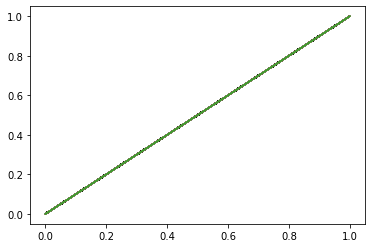

In [102]:
plt.plot(np.unique(sv_test.isnull(), axis=0))

In [55]:
sv_groupby_bins

<xarray.DataArray 'Sv' (ping_time: 51, echo_range_bins: 40)>
array([[4.79887022e-01, 8.57151612e-06, 1.59880170e-06, ...,
        6.22452421e-09, 3.40579320e-09, 1.20002002e-08],
       [4.80525694e-01, 9.09494938e-06, 1.42344314e-06, ...,
        8.51669775e-09, 8.71384121e-09, 1.04514642e-08],
       [4.80012521e-01, 9.50437731e-06, 1.24697187e-06, ...,
        1.15305747e-08, 1.45419015e-08, 9.68941580e-09],
       ...,
       [4.80528352e-01, 1.62151616e-06, 1.12775627e-07, ...,
        1.04568883e-08, 1.29287127e-08, 1.08770807e-08],
       [4.80312179e-01, 9.34718306e-07, 5.93680784e-08, ...,
        4.40967562e-09, 4.81857723e-09, 4.48776974e-09],
       [4.80447186e-01, 1.00914678e-06, 4.84632486e-08, ...,
        1.45141821e-08, 7.99750666e-09, 6.27075657e-09]])
Coordinates:
  * echo_range_bins  (echo_range_bins) object [0.0, 20.0) ... [780.0, 800.0)
  * ping_time        (ping_time) datetime64[ns] 2010-03-18T02:30:00 ... 2010-...
    channel          <U37 'GPT  18 kHz 009072034d45 1-1 ES18-11'

In [81]:
(
    ds_Sv.groupby("channel")
    .apply(_freq_MVBS, args=(range_interval, ping_time_bin))
)

<xarray.DataArray 'Sv' (channel: 6, ping_time: 51, echo_range: 40)>
array([[[  -3.18860995,  -50.66942354,  -57.96205398, ...,
          -82.05893839,  -84.67781726,  -79.20811509],
        [  -3.18283386,  -50.41199714,  -58.46659877, ...,
          -80.69728765,  -80.59790359,  -79.80822862],
        [  -3.18747434,  -50.22076331,  -59.04143345, ...,
          -79.38149046,  -78.37378801,  -80.13702407],
        ...,
        [  -3.18280983,  -57.90078718,  -69.47784748, ...,
          -79.80597531,  -78.88444715,  -79.63487649],
        [  -3.18476402,  -60.29319252,  -72.26447008, ...,
          -83.55593357,  -83.17081176,  -83.47969434],
        [  -3.18354346,  -59.96045661,  -73.14587477, ...,
          -78.38207433,  -80.9704539 ,  -82.02680058]],

       [[   4.64420902,  -51.41027519,  -58.37687793, ...,
          -44.90558845,  -41.72494527,  -43.96915614],
        [   4.64182808,  -51.98225977,  -58.68866949, ...,
          -46.00037948,  -43.01083223,  -40.68581401],
        [   4.63908259,  -52.22487418,  -59.63209921, ...,
          -47.36969844,  -39.7499647 ,  -40.56602447],
...
        [   8.34108162,  -73.282733  ,  -81.11421976, ...,
          -34.22571163,  -35.65215639,  -35.27672024],
        [   8.34035631,  -78.10012588,  -90.77470622, ...,
          -41.32021535,  -40.22792594,  -38.98287611],
        [   8.34058786,  -76.2875799 ,  -91.44598027, ...,
          -43.41570819,  -40.11438053,  -37.79743606]],

       [[  14.6279332 ,  -57.35158077,  -65.29620137, ...,
           -0.9012435 ,   -9.56480244,    0.45337551],
        [  14.63180385,  -60.32329879,  -66.35439002, ...,
           -3.11213553,   -3.71676346,    4.72480859],
        [  14.63113181,  -62.43079294,  -69.84968506, ...,
           -8.33127365,    0.8122855 ,    0.81249825],
        ...,
        [  14.63410564,  -71.51567107,  -79.69671778, ...,
           -4.84113085,   -7.84261257,   -7.09726416],
        [  14.63362672,  -78.37994417,  -88.60707221, ...,
          -12.79568739,  -10.87655014,   -9.23475554],
        [  14.63304181,  -75.24537892,  -89.3487173 , ...,
          -14.03019991,   -9.47326691,   -6.99421097]]])
Coordinates:
  * ping_time   (ping_time) datetime64[ns] 2010-03-18T02:30:00 ... 2010-03-18...
  * channel     (channel) <U37 'GPT  18 kHz 009072034d45 1-1 ES18-11' ... 'GP...
  * echo_range  (echo_range) float64 0.0 20.0 40.0 60.0 ... 740.0 760.0 780.0

ImportError: cannot import name 'FrameOrSeries' from 'pandas._typing' (/Users/wu-jung/miniconda3/envs/echopype/lib/python3.9/site-packages/pandas/_typing.py)

In [354]:
ds_MVBS = (
    ds_Sv.groupby("channel")
    .apply(_freq_MVBS, args=(range_interval, ping_time_bin))
    .to_dataset()
)

ImportError: cannot import name 'FrameOrSeries' from 'pandas._typing' (/Users/wu-jung/miniconda3/envs/echopype/lib/python3.9/site-packages/pandas/_typing.py)

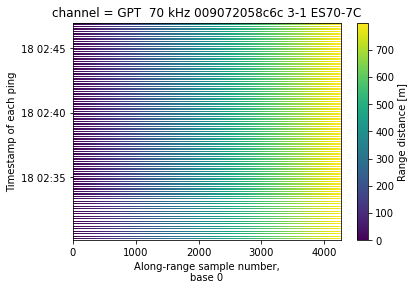

In [140]:
Sv["echo_range"].isel(channel=2).plot()

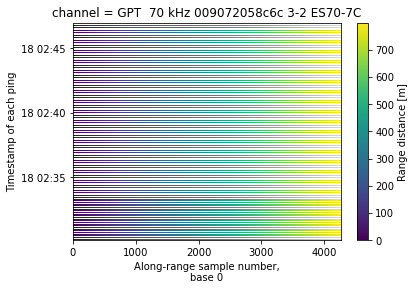

In [141]:
Sv["echo_range"].isel(channel=3).plot()

In [117]:
Sv_swapped = ep.utils.swap_dims_channel_frequency(Sv)

ValueError: Duplicated transducer nominal frequencies exist in the file. Operation is not valid.

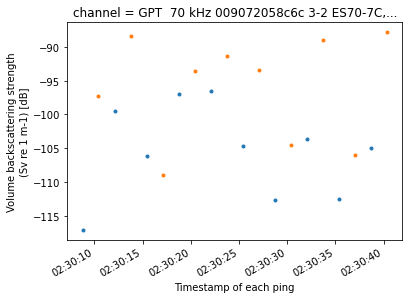

In [118]:
Sv["Sv"].isel(range_sample=100, channel=2, ping_time=slice(None, 20)).plot(marker='.')
Sv["Sv"].isel(range_sample=100, channel=3, ping_time=slice(None, 20)).plot(marker='.')

In [76]:
def get_sv(ch):
    ds = Sv.isel(channel=ch).copy()
    sv = 10 ** (ds["Sv"] / 10)
    sv.coords["echo_range"] = (
        ["range_sample"],
        ds["echo_range"].isel(ping_time=0).squeeze().drop("channel").data,
    )
    sv = sv.swap_dims({"range_sample": "echo_range"})
    return sv

In [77]:
sv2 = get_sv(ch=2)
sv3 = get_sv(ch=3)

In [111]:
Sv["echo_range"].isel(channel=2, ping_time=0).dropna(dim="range_sample")

<xarray.DataArray 'echo_range' (range_sample: 3730)>
array([  0.        ,   0.        ,   0.        , ..., 698.98879824,
       699.17644623, 699.36409423])
Coordinates:
    channel       <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'
    ping_time     datetime64[ns] 2010-03-18T02:30:08.778999808
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 3725 3726 3727 3728 3729
Attributes:
    long_name:  Range distance
    units:      m

In [112]:
Sv["echo_range"].isel(channel=2).dropna(dim="range_sample")

<xarray.DataArray 'echo_range' (ping_time: 609, range_sample: 0)>
array([], shape=(609, 0), dtype=float64)
Coordinates:
    channel       <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'
  * ping_time     (ping_time) datetime64[ns] 2010-03-18T02:30:08.778999808 .....
  * range_sample  (range_sample) int64 
Attributes:
    long_name:  Range distance
    units:      m

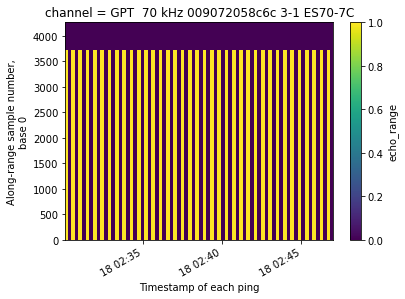

In [115]:
(
    Sv["echo_range"].isel(channel=2, ping_time=0)
    == Sv["echo_range"].isel(channel=2)
).plot()

In [118]:
A = (
    Sv["echo_range"].isel(channel=2, ping_time=0)
    == Sv["echo_range"].isel(channel=2)
)

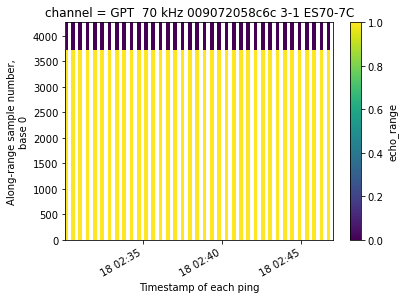

In [127]:
A.where(~Sv["echo_range"].isel(channel=2).isnull()).plot()

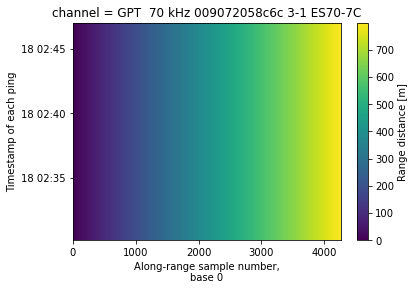

In [129]:
Sv["echo_range"].isel(channel=2).dropna(dim="ping_time").plot()

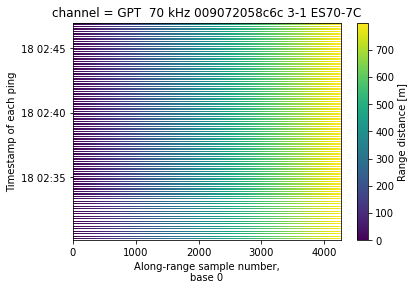

In [130]:
Sv["echo_range"].isel(channel=2).plot()

In [131]:
sv_test = Sv["echo_range"].isel(channel=2).copy()

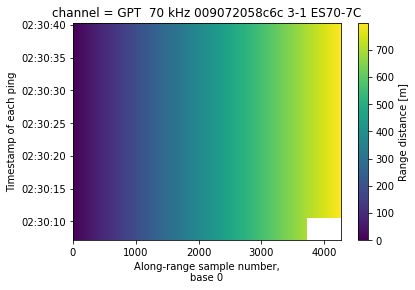

In [141]:
sv_test.dropna(dim="ping_time", how="all").isel(ping_time=slice(None,10)).plot()

In [143]:
sv = Sv["Sv"].isel(channel=2).copy()

In [148]:
sv

<xarray.DataArray 'Sv' (ping_time: 609, range_sample: 4263)>
array([[ -95.45264671, -120.26410148, -131.45865867, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [ -81.17724083, -122.99218986, -132.21123741, ...,  -76.51711819,
         -72.96834362,  -69.76058821],
       ...,
       [ -68.53633354, -109.10483024, -120.12299583, ...,  -76.95219204,
         -74.14424694,  -67.23240523],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [ -77.143908  , -117.08917472, -129.98878715, ...,  -66.03986905,
         -74.34415234,  -72.53570418]])
Coordinates:
    channel       <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'
  * ping_time     (ping_time) datetime64[ns] 2010-03-18T02:30:08.778999808 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 4258 4259 4260 4261 4262
Attributes:
    long_name:     Volume backscattering strength (Sv re 1 m-1)
    units:         dB
    actual_range:  [-181.26, 29.71]

In [150]:
sv = sv.assign_coords({"echo_range": Sv["echo_range"].isel(channel=2)})

In [153]:
import numpy as np

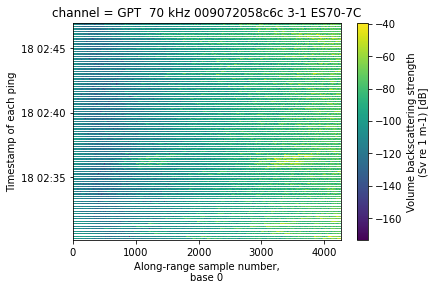

In [166]:
sv.plot()

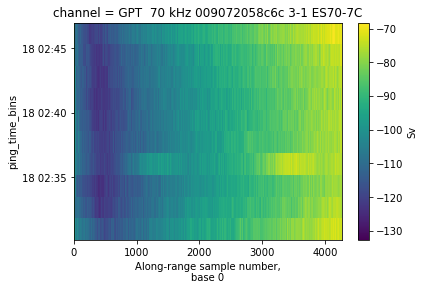

In [165]:
sv.groupby_bins("ping_time", bins=10).mean().plot()

In [171]:
sv.groupby_bins("echo_range", np.arange(0,820, 20))

DataArrayGroupBy, grouped over 'echo_range_bins'
40 groups with labels (0.0,, 20.0], ..., (780.0,, 800.0].

In [172]:
Sv["echo_range"].groupby_bins("ping_time", bins=10).mean()

<xarray.DataArray 'echo_range' (channel: 6, ping_time_bins: 10,
                                range_sample: 4263)>
array([[[  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        ...,
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798]],

       [[  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
...
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798]],

       [[  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        ...,
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798],
        [  0.        ,   0.        ,   0.        , ..., 799.00518198,
         799.19282998, 799.38047798]]])
Coordinates:
  * ping_time_bins  (ping_time_bins) object (2010-03-18 02:30:07.768915712, 2...
  * channel         (channel) <U37 'GPT  18 kHz 009072034d45 1-1 ES18-11' ......
  * range_sample    (range_sample) int64 0 1 2 3 4 ... 4258 4259 4260 4261 4262

In [206]:
sv_ping_new = sv.resample(ping_time="20S").mean()

In [208]:
A_new = (
    sv_ping_new.assign_coords(
        {"echo_range": Sv["echo_range"].isel(channel=2).resample(ping_time="20S").mean()}
    )
)

In [209]:
A_new

<xarray.DataArray 'Sv' (ping_time: 51, range_sample: 4263)>
array([[ -86.65986679, -119.54974411, -129.51254699, ...,  -72.46810696,
         -66.99086051,  -67.80859745],
       [ -70.40209307, -108.36597043, -127.22934069, ...,  -75.75669898,
         -77.63862408,  -75.77726861],
       [ -90.04155586, -120.55024065, -131.22543698, ...,  -75.27066332,
         -72.26084952,  -75.42645888],
       ...,
       [ -81.37518292, -115.95835604, -133.03436261, ...,  -69.64791144,
         -72.67437288,  -69.90561792],
       [ -74.56673159, -110.7922425 , -127.8231708 , ...,  -73.19715919,
         -71.61802472,  -72.32208622],
       [ -84.35412707, -117.60461408, -131.1156856 , ...,  -69.8752496 ,
         -70.27750195,  -67.48718377]])
Coordinates:
  * ping_time     (ping_time) datetime64[ns] 2010-03-18T02:30:00 ... 2010-03-...
    channel       <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 4258 4259 4260 4261 4262
    echo_range    (ping_time, range_sample) float64 0.0 0.0 0.0 ... 799.2 799.4

In [211]:
A_new.groupby("ping_time").apply(test)

<xarray.DataArray 'Sv' (ping_time: 51, echo_range_bins: 40)>
array([[-100.51134875, -103.38382907, -107.28099498, ...,  -75.82328883,
         -76.26193329,  -72.72825271],
       [-100.53752908, -104.5585183 , -108.88876812, ...,  -76.90458412,
         -71.15137951,  -72.52399699],
       [-103.63280431, -108.97932855, -112.1145019 , ...,  -75.27561721,
         -74.48800953,  -74.37044   ],
       ...,
       [-106.85132692, -115.47777905, -118.53716256, ...,  -71.63018541,
         -71.75942584,  -71.2089319 ],
       [-107.97704656, -116.60801527, -120.90352863, ...,  -76.63561138,
         -75.14525523,  -74.30461649],
       [-108.50213286, -117.08712939, -119.93295   , ...,  -74.87192846,
         -73.79544958,  -73.27909724]])
Coordinates:
  * echo_range_bins  (echo_range_bins) object (0, 20] (20, 40] ... (780, 800]
  * ping_time        (ping_time) datetime64[ns] 2010-03-18T02:30:00 ... 2010-...
    channel          <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'

In [212]:
sv3 = sv = Sv["Sv"].isel(channel=3).copy()

In [213]:
sv3_ping = sv3.resample(ping_time="20S").mean()

In [214]:
A3_new = (
    sv3_ping.assign_coords(
        {"echo_range": Sv["echo_range"].isel(channel=3).resample(ping_time="20S").mean()}
    )
)

In [215]:
A3_new.groupby("ping_time").apply(test)

<xarray.DataArray 'Sv' (ping_time: 51, echo_range_bins: 40)>
array([[ -95.5368362 , -101.86536319, -105.09717953, ...,  -72.29196715,
         -71.15934759,  -69.4183622 ],
       [-100.76612664, -103.62660996, -107.95111848, ...,  -72.80767714,
         -73.30225613,  -70.28249697],
       [-107.84599671, -104.20279989, -107.38273042, ...,  -69.75351017,
         -70.76651284,  -67.72859272],
       ...,
       [-111.00711107, -114.58867534, -111.16252282, ...,  -60.93211087,
         -61.08873946,  -59.73495219],
       [-112.98363714, -119.24770585, -115.75629228, ...,  -66.01549004,
         -64.96589469,  -63.45422087],
       [-114.7579126 , -119.38972957, -115.94486076, ...,  -67.15310775,
         -65.92985399,  -65.15691816]])
Coordinates:
  * echo_range_bins  (echo_range_bins) object (0, 20] (20, 40] ... (780, 800]
  * ping_time        (ping_time) datetime64[ns] 2010-03-18T02:30:00 ... 2010-...
    channel          <U37 'GPT  70 kHz 009072058c6c 3-2 ES70-7C'

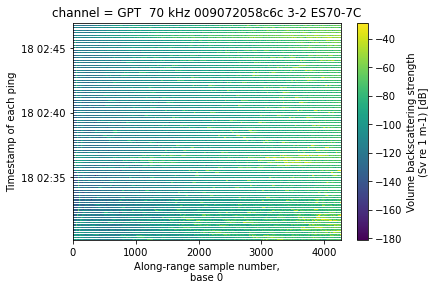

In [216]:
sv3.plot()

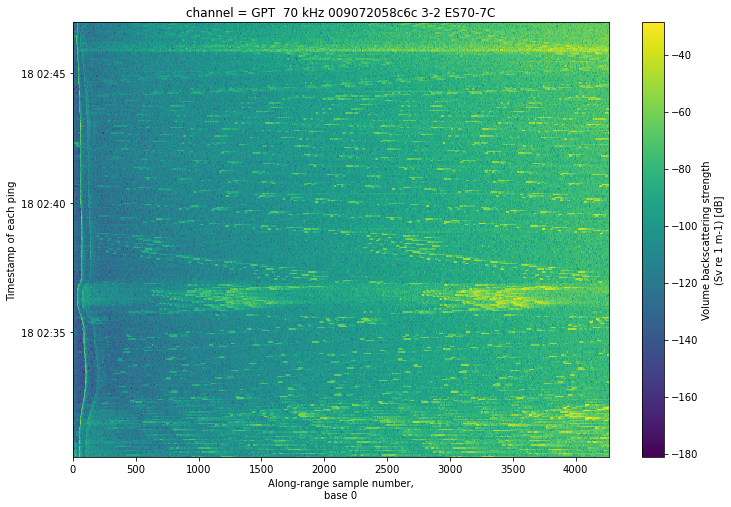

In [222]:
sv3.dropna("ping_time", how="all").plot(figsize=(12,8))

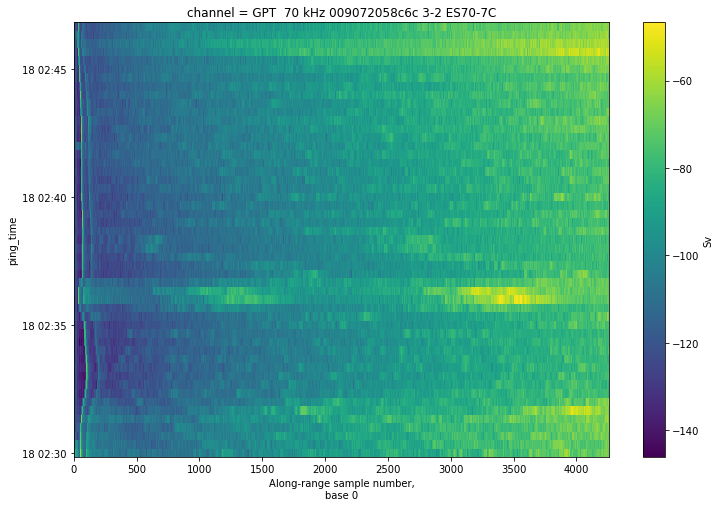

In [221]:
A3_new.plot(figsize=(12,8))

In [173]:
sv_ping = sv.groupby_bins("ping_time", bins=10).mean()

In [178]:
sv_ping.assign_coords({"echo_range": Sv["echo_range"].isel(channel=2).groupby_bins("ping_time", bins=10).mean()})

<xarray.DataArray 'Sv' (ping_time_bins: 10, range_sample: 4263)>
array([[ -78.29591052, -113.73217739, -128.49159994, ...,  -73.99402935,
         -72.95423535,  -73.10210077],
       [ -77.10353668, -113.47681892, -132.7454822 , ...,  -75.66067034,
         -76.85312298,  -77.12876702],
       [ -79.60495071, -116.7003729 , -129.80519143, ...,  -76.50763165,
         -77.44927801,  -76.2268909 ],
       ...,
       [ -77.77623948, -113.92449424, -130.6939428 , ...,  -74.31439238,
         -73.94092949,  -74.9174717 ],
       [ -78.00192382, -115.16540814, -131.79692339, ...,  -71.44938748,
         -71.45810294,  -70.44692142],
       [ -75.4123037 , -112.09464451, -131.00878084, ...,  -69.96887827,
         -70.53423797,  -69.17870857]])
Coordinates:
  * ping_time_bins  (ping_time_bins) object (2010-03-18 02:30:07.768915712, 2...
    channel         <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'
  * range_sample    (range_sample) int64 0 1 2 3 4 ... 4258 4259 4260 4261 4262
    echo_range      (ping_time_bins, range_sample) float64 0.0 0.0 ... 799.4

In [179]:
A = sv_ping.assign_coords({"echo_range": Sv["echo_range"].isel(channel=2).groupby_bins("ping_time", bins=10).mean()})

In [183]:
def test(ds):
    return ds.groupby_bins("echo_range", bins=np.arange(0,820,20)).mean()

In [188]:
A.groupby("ping_time_bins").apply(test)

<xarray.DataArray 'Sv' (ping_time_bins: 10, echo_range_bins: 40)>
array([[-102.70452983, -107.44967759, -110.96735343, -114.92060545,
        -117.43798446, -114.96544984, -115.32623494, -113.18827919,
        -112.01473948, -109.7051345 , -108.60384344, -105.45950555,
        -104.02784089, -102.11826637, -101.07379004, -100.29648202,
         -98.18590519,  -95.43080737,  -95.95918537,  -94.75112757,
         -94.2802652 ,  -93.6076646 ,  -91.54840341,  -92.3018848 ,
         -88.95871742,  -87.47653109,  -87.23415653,  -85.74917398,
         -85.17280385,  -84.63064346,  -82.46798277,  -81.22086325,
         -80.53125511,  -79.57306904,  -77.96012412,  -77.81020347,
         -75.63853718,  -74.23403839,  -73.61165448,  -73.10187195],
       [-106.75344651, -113.27874275, -116.48665437, -121.3281098 ,
        -121.41985995, -119.91505745, -117.17349824, -116.19538606,
        -114.26586746, -112.07409946, -109.90770615, -109.44944473,
        -107.70749171, -105.14239902, -103.86304465, -103.74120121,
        -100.86857845,  -98.57193878,  -98.09431635,  -96.83188008,
         -96.72134126,  -95.20820127,  -93.74197828,  -93.2099849 ,
         -92.80034433,  -90.94622825,  -88.87525559,  -89.15675529,
         -88.31021183,  -86.46035858,  -85.60151374,  -83.44969849,
         -84.18789487,  -83.0910597 ,  -80.30670671,  -79.76416933,
         -79.29693302,  -77.1095166 ,  -76.21967134,  -75.07411731],
...
       [-107.92957407, -115.7316962 , -119.0883184 , -121.6798793 ,
        -119.62197801, -118.44149557, -116.42609954, -113.5042722 ,
        -111.98589199, -110.46155442, -108.93369578, -106.25199583,
        -105.08462662, -104.77380058, -102.90023507, -100.69382202,
        -100.04894023,  -99.08138862,  -96.04972554,  -95.65818571,
         -95.4309374 ,  -92.62314756,  -92.0594471 ,  -91.71223054,
         -89.99872062,  -89.40974313,  -88.32679878,  -87.00056047,
         -85.50885945,  -85.44357657,  -83.16815867,  -81.94908562,
         -82.02754222,  -80.79521442,  -79.39907815,  -78.31032625,
         -77.53417694,  -75.8674455 ,  -75.27466686,  -74.45149786],
       [-107.91395662, -116.25138861, -119.60321783, -119.94266313,
        -117.59853067, -114.61218059, -112.27321694, -109.37967099,
        -107.29354466, -105.69898176, -103.77733543, -102.58458793,
        -101.71076818, -100.03448716,  -99.0482961 ,  -96.9892403 ,
         -95.52419515,  -94.66701921,  -93.06718067,  -92.64573263,
         -91.20678162,  -90.09390781,  -89.17974977,  -88.65662134,
         -87.29640408,  -85.92896422,  -84.74958633,  -82.45282255,
         -81.37789774,  -80.35454932,  -79.57608805,  -78.69471422,
         -77.99017301,  -76.76679771,  -75.82197628,  -74.35469578,
         -73.62431034,  -72.53695836,  -70.9989018 ,  -71.22102153]])
Coordinates:
  * echo_range_bins  (echo_range_bins) object (0, 20] (20, 40] ... (780, 800]
  * ping_time_bins   (ping_time_bins) object (2010-03-18 02:30:07.768915712, ...
    channel          <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'

In [134]:
def test(ds):
    ds = ds.assign_coords({"echo_range": ds["echo_range"]})
    return ds.groupby_bins("echo_range", bins=np.arange(0,820,20)).mean()

In [132]:
Sv.isel(channel=0, ping_time=0)

<xarray.Dataset>
Dimensions:                (range_sample: 4263, filenames: 1, time3: 609)
Coordinates:
    channel                <U37 'GPT  18 kHz 009072034d45 1-1 ES18-11'
    ping_time              datetime64[ns] 2010-03-18T02:30:08.778999808
  * range_sample           (range_sample) int64 0 1 2 3 ... 4259 4260 4261 4262
  * time3                  (time3) datetime64[ns] 2010-03-18T02:30:08.7789998...
Dimensions without coordinates: filenames
Data variables:
    Sv                     (range_sample) float64 0.7307 12.31 12.13 ... nan nan
    echo_range             (range_sample) float64 0.0 0.0 0.0 ... nan nan nan
    frequency_nominal      float64 1.8e+04
    sound_speed            float64 1.466e+03
    sound_absorption       float64 0.003004
    sa_correction          float64 -0.58
    gain_correction        float64 23.0
    equivalent_beam_angle  float64 -17.47
    source_filenames       (filenames) <U99 '/Users/wu-jung/code_git/echopype...
    water_level            (time3) float64 dask.array<chunksize=(609,), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.6.0
    processing_time:              2022-07-04T04:26:52Z
    processing_function:          calibrate.compute_Sv

In [137]:
Sv.isel(channel=0)

<xarray.Dataset>
Dimensions:                (ping_time: 609, range_sample: 4263, filenames: 1,
                            time3: 609)
Coordinates:
    channel                <U37 'GPT  18 kHz 009072034d45 1-1 ES18-11'
  * ping_time              (ping_time) datetime64[ns] 2010-03-18T02:30:08.778...
  * range_sample           (range_sample) int64 0 1 2 3 ... 4259 4260 4261 4262
  * time3                  (time3) datetime64[ns] 2010-03-18T02:30:08.7789998...
Dimensions without coordinates: filenames
Data variables:
    Sv                     (ping_time, range_sample) float64 0.7307 ... -86.17
    echo_range             (ping_time, range_sample) float64 0.0 0.0 ... 799.4
    frequency_nominal      float64 1.8e+04
    sound_speed            (ping_time) float64 1.466e+03 1.466e+03 ... 1.466e+03
    sound_absorption       (ping_time) float64 0.003004 0.003004 ... 0.003004
    sa_correction          (ping_time) float64 -0.58 -0.58 -0.58 ... -0.58 -0.58
    gain_correction        (ping_time) float64 23.0 23.0 23.0 ... 23.0 23.0 23.0
    equivalent_beam_angle  (ping_time) float64 -17.47 -17.47 ... -17.47 -17.47
    source_filenames       (filenames) <U99 '/Users/wu-jung/code_git/echopype...
    water_level            (time3) float64 dask.array<chunksize=(609,), meta=np.ndarray>
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.6.0
    processing_time:              2022-07-04T04:26:52Z
    processing_function:          calibrate.compute_Sv

In [ ]:
def _sub(data, echo_range_bins):
    print(f"data: {data.shape}")
    return ds.groupby_bins("echo_range", bins=np.arange(0,820,20)).mean()

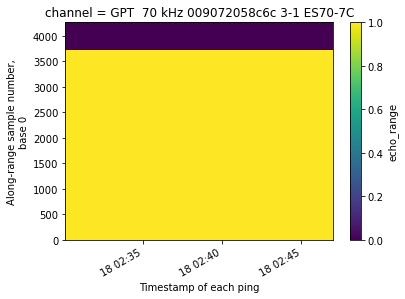

In [139]:
(
    sv_test.dropna(dim="ping_time", how="all").isel(ping_time=0)
    == sv_test.dropna(dim="ping_time", how="all")
).plot()

In [136]:
sv_test.dropna(dim="ping_time", how="all").isel(ping_time=0)

<xarray.DataArray 'echo_range' (range_sample: 4263)>
array([ 0.,  0.,  0., ..., nan, nan, nan])
Coordinates:
    channel       <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'
    ping_time     datetime64[ns] 2010-03-18T02:30:08.778999808
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 4258 4259 4260 4261 4262
Attributes:
    long_name:  Range distance
    units:      m

In [137]:
sv_test.dropna(dim="ping_time", how="all")

<xarray.DataArray 'echo_range' (ping_time: 305, range_sample: 4263)>
array([[  0.        ,   0.        ,   0.        , ...,          nan,
                 nan,          nan],
       [  0.        ,   0.        ,   0.        , ..., 799.00518198,
        799.19282998, 799.38047798],
       [  0.        ,   0.        ,   0.        , ..., 799.00518198,
        799.19282998, 799.38047798],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 799.00518198,
        799.19282998, 799.38047798],
       [  0.        ,   0.        ,   0.        , ..., 799.00518198,
        799.19282998, 799.38047798],
       [  0.        ,   0.        ,   0.        , ..., 799.00518198,
        799.19282998, 799.38047798]])
Coordinates:
    channel       <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'
  * ping_time     (ping_time) datetime64[ns] 2010-03-18T02:30:08.778999808 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 4258 4259 4260 4261 4262
Attributes:
    long_name:  Range distance
    units:      m

<xarray.DataArray 'echo_range' (channel: 6, ping_time: 609, range_sample: 4263)>
array([[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * channel       (channel) <U37 'GPT  18 kHz 009072034d45 1-1 ES18-11' ... '...
  * ping_time     (ping_time) datetime64[ns] 2010-03-18T02:30:08.778999808 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 4258 4259 4260 4261 4262

In [101]:
def _check_range_uniqueness(ds):
    """
    Check if range (``echo_range``) changes across ping in a given frequency channel.
    """
    return (
        ds["echo_range"].isel(ping_time=0).dropna(dim="range_sample")
        == ds["echo_range"].dropna(dim="range_sample")
    ).all()

In [102]:
Sv.groupby("channel").apply(_check_range_uniqueness)

<xarray.DataArray 'echo_range' (channel: 6)>
array([ True,  True,  True,  True,  True,  True])
Coordinates:
  * channel  (channel) <U37 'GPT  18 kHz 009072034d45 1-1 ES18-11' ... 'GPT 2...

In [189]:
import pandas as pd

In [204]:
np.array(list(sv.resample(ping_time="20S").groups.keys()))

array(['2010-03-18T02:30:00.000000000', '2010-03-18T02:30:20.000000000',
       '2010-03-18T02:30:40.000000000', '2010-03-18T02:31:00.000000000',
       '2010-03-18T02:31:20.000000000', '2010-03-18T02:31:40.000000000',
       '2010-03-18T02:32:00.000000000', '2010-03-18T02:32:20.000000000',
       '2010-03-18T02:32:40.000000000', '2010-03-18T02:33:00.000000000',
       '2010-03-18T02:33:20.000000000', '2010-03-18T02:33:40.000000000',
       '2010-03-18T02:34:00.000000000', '2010-03-18T02:34:20.000000000',
       '2010-03-18T02:34:40.000000000', '2010-03-18T02:35:00.000000000',
       '2010-03-18T02:35:20.000000000', '2010-03-18T02:35:40.000000000',
       '2010-03-18T02:36:00.000000000', '2010-03-18T02:36:20.000000000',
       '2010-03-18T02:36:40.000000000', '2010-03-18T02:37:00.000000000',
       '2010-03-18T02:37:20.000000000', '2010-03-18T02:37:40.000000000',
       '2010-03-18T02:38:00.000000000', '2010-03-18T02:38:20.000000000',
       '2010-03-18T02:38:40.000000000', '2010-03-18

In [100]:
Sv["echo_range"].isel(channel=2)#.dropna(dim="range_sample")

<xarray.DataArray 'echo_range' (ping_time: 609, range_sample: 4263)>
array([[  0.        ,   0.        ,   0.        , ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [  0.        ,   0.        ,   0.        , ..., 799.00518198,
        799.19282998, 799.38047798],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 799.00518198,
        799.19282998, 799.38047798],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [  0.        ,   0.        ,   0.        , ..., 799.00518198,
        799.19282998, 799.38047798]])
Coordinates:
    channel       <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'
  * ping_time     (ping_time) datetime64[ns] 2010-03-18T02:30:08.778999808 .....
  * range_sample  (range_sample) int64 0 1 2 3 4 5 ... 4258 4259 4260 4261 4262
Attributes:
    long_name:  Range distance
    units:      m

In [68]:
import matplotlib.pyplot as plt

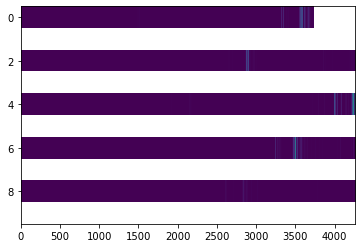

In [80]:
plt.imshow(sv2.isel(ping_time=slice(None, 10)).values, aspect="auto", interpolation="none")

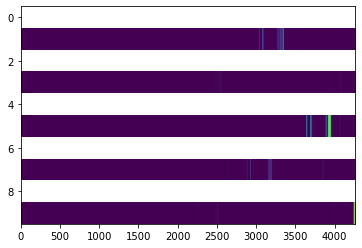

In [81]:
plt.imshow(sv3.isel(ping_time=slice(None, 10)).values, aspect="auto", interpolation="none")

In [70]:
rint=20

In [84]:
(
    sv2.groupby_bins("echo_range", bins=rint, right=False, include_lowest=True)
    .mean(skipna=True)
)

<xarray.DataArray 'Sv' (ping_time: 609, echo_range_bins: 20)>
array([[1.68973614e-10, 2.38140237e-11, 3.38937454e-12, ...,
        1.84197846e-07, 7.36239495e-08, 8.82160132e-07],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [2.17578219e-10, 3.33585818e-11, 4.09503270e-12, ...,
        5.47044864e-09, 5.41265577e-09, 1.39145536e-08],
       ...,
       [8.24837813e-10, 2.58190958e-12, 7.70517792e-11, ...,
        1.38487446e-08, 1.84075263e-08, 3.20224369e-08],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [1.72176561e-10, 2.29835781e-12, 3.02797664e-11, ...,
        6.17500811e-08, 9.67031921e-08, 1.35740843e-07]])
Coordinates:
  * echo_range_bins  (echo_range_bins) object [0.0, 34.968) ... [664.396, 700...
    channel          <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'
  * ping_time        (ping_time) datetime64[ns] 2010-03-18T02:30:08.778999808...

In [87]:
sv3["echo_range"]

<xarray.DataArray 'echo_range' (echo_range: 4263)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
    channel       <U37 'GPT  70 kHz 009072058c6c 3-2 ES70-7C'
    range_sample  (echo_range) int64 0 1 2 3 4 5 ... 4258 4259 4260 4261 4262
  * echo_range    (echo_range) float64 nan nan nan nan nan ... nan nan nan nan

In [86]:
(
    sv3.groupby_bins("echo_range", bins=rint, right=False, include_lowest=True)
    .mean(skipna=True)
)

ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [191]:
sv2["ping_time"]

<xarray.DataArray 'ping_time' (ping_time: 609)>
array(['2010-03-18T02:30:08.778999808', '2010-03-18T02:30:10.435999744',
       '2010-03-18T02:30:12.108000256', ..., '2010-03-18T02:46:55.535000064',
       '2010-03-18T02:46:57.191000064', '2010-03-18T02:46:58.863000064'],
      dtype='datetime64[ns]')
Coordinates:
    channel    <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'
  * ping_time  (ping_time) datetime64[ns] 2010-03-18T02:30:08.778999808 ... 2...
Attributes:
    long_name:      Timestamp of each ping
    standard_name:  time
    axis:           T

In [190]:
(
    sv2.groupby_bins("echo_range", bins=rint, right=False, include_lowest=True)
    .mean(skipna=True)
    .resample(ping_time="20S", skipna=True).mean(skipna=True)
)

<xarray.DataArray 'Sv' (ping_time: 51, echo_range_bins: 20)>
array([[2.11960995e-10, 3.31265550e-11, 4.35093844e-12, ...,
        9.41363748e-08, 1.93647831e-07, 2.83205676e-07],
       [2.50842229e-09, 3.21077191e-11, 1.44561188e-11, ...,
        8.27475756e-08, 1.80003756e-07, 2.64006083e-08],
       [1.19613282e-10, 1.37663613e-11, 9.90699551e-12, ...,
        1.99378748e-07, 1.68515635e-08, 1.06935063e-07],
       ...,
       [1.47977878e-10, 2.88055860e-12, 5.12544654e-12, ...,
        7.05075669e-08, 1.47431921e-07, 2.72788162e-07],
       [1.27879281e-09, 1.72409646e-12, 1.82955692e-12, ...,
        7.89706413e-08, 5.57648136e-08, 2.92913112e-08],
       [2.17555118e-10, 2.48825029e-12, 2.59938195e-11, ...,
        4.45184075e-08, 3.20107591e-08, 4.35122971e-08]])
Coordinates:
  * ping_time        (ping_time) datetime64[ns] 2010-03-18T02:30:00 ... 2010-...
  * echo_range_bins  (echo_range_bins) object [0.0, 34.968) ... [664.396, 700...
    channel          <U37 'GPT  70 kHz 009072058c6c 3-1 ES70-7C'

In [63]:
MVBS = ep.preprocess.compute_MVBS(Sv)

ValueError: None of the data falls within bins with edges array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
       220., 240., 260., 280., 300., 320., 340., 360., 380., 400., 420.,
       440., 460., 480., 500., 520., 540., 560., 580., 600., 620., 640.,
       660., 680., 700., 720., 740., 760., 780., 800.])

In [5]:
import numpy as np
import pandas as pd
import xarray as xr

In [13]:
t = pd.date_range("2015-08-10T01:00:00", "2015-08-10T02:00:00", periods=61)

In [94]:
t = pd.date_range("2015-08-10T01:00:00", "2015-08-10T02:00:00", periods=21)

In [95]:
len(t)

21

In [85]:
ds = xr.Dataset(
    {
        "Sv": (
            ("ping_time", "range_sample"),
            np.random.uniform(size=(61, 100))
        ),
    },
    coords={
        "ping_time": pd.date_range("2015-08-10T01:00:00", "2015-08-10T02:00:00", periods=61),
        "range_sample": np.arange(100)
    }
)

In [86]:
er1 = np.array([np.arange(100)] * 20)
er2 = np.array([np.arange(100)*1.5] * 41)

In [87]:
ds = ds.assign_coords({"echo_range": (("ping_time", "range_sample"), np.vstack((er1, er2)))})
ds = ds.assign_coords({"time": (("ping_time", "range_sample"), np.array([ds["ping_time"].values]*100).T)})

In [88]:
ds

<xarray.Dataset>
Dimensions:       (ping_time: 61, range_sample: 100)
Coordinates:
  * ping_time     (ping_time) datetime64[ns] 2015-08-10T01:00:00 ... 2015-08-...
  * range_sample  (range_sample) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    echo_range    (ping_time, range_sample) float64 0.0 1.0 2.0 ... 147.0 148.5
    time          (ping_time, range_sample) datetime64[ns] 2015-08-10T01:00:0...
Data variables:
    Sv            (ping_time, range_sample) float64 0.3969 0.4524 ... 0.7059

In [106]:
import xesmf as xe

In [107]:
ds_renamed = ds.rename({"time": "lon", "echo_range": "lat"})

In [108]:
ds_renamed

<xarray.Dataset>
Dimensions:       (ping_time: 61, range_sample: 100)
Coordinates:
  * ping_time     (ping_time) datetime64[ns] 2015-08-10T01:00:00 ... 2015-08-...
  * range_sample  (range_sample) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    lat           (ping_time, range_sample) float64 0.0 1.0 2.0 ... 147.0 148.5
    lon           (ping_time, range_sample) datetime64[ns] 2015-08-10T01:00:0...
Data variables:
    Sv            (ping_time, range_sample) float64 0.3969 0.4524 ... 0.7059

In [109]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(0, 100, 20)),
        "lon": (["lon"], pd.date_range("2015-08-10T01:00:00", "2015-08-10T02:00:00", periods=21))
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 21)
Coordinates:
  * lat      (lat) int64 0 20 40 60 80
  * lon      (lon) datetime64[ns] 2015-08-10T01:00:00 ... 2015-08-10T02:00:00
Data variables:
    *empty*

In [110]:
regridder = xe.Regridder(ds_renamed, ds_out, "bilinear")

Create weight file: bilinear_61x100_5x21.nc


ImportError: Regrid(filename) requires PIO and does not work if ESMF has not been built with MPI support